**Machine Learning for Time Series (Master MVA)**

- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this notebook, we illustrate the following concept:
- change point detection.

## Setup

**Import**

In [8]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [7]:
!pip install ruptures
!pip install loadmydata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 17.9 MB/s eta 0:00:00
  Created wheel for loadmydata: filename=loadmydata-0.0.10-py3-none-any.whl size=17927 sha256=9c23b590113e574bf021b0dd6f78f0dcefe096d8be56d737237cd3fc8dcc2471
  Stored in directory: /root/.cache/pip/wheels/be/26/25/f6440e22a0dbb908595bec27cf70ba8de86717266845684da6
Successfully built loadmydata


In [9]:
import datetime as dt
from math import log
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.dates import DateFormatter
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.stats import ttest_ind
from scipy.optimize import minimize
from scipy.signal import chirp, stft, sweep_poly
rng = np.random.default_rng()

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Utility functions**

In [10]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

In [11]:
myFmt = DateFormatter("%H:%M")

def plot_clinear_approx(time_index, signal, bkps, ax=None):
    # plot
    ax.plot(time_index, signal)
    # plot changes
    for b in bkps[:-1]:
        ax.axvline(time_index[b], ls="--", color="k")
    # add linear approximation
    indexes = np.r_[0, np.array(bkps) - 1]
    ax.plot(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="k",
        alpha=0.5,
    )
    ax.scatter(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="r",
        alpha=0.5,
        s=100,
        marker="*",
    )
    ax.margins(x=0)
    ax.xaxis.set_major_formatter(myFmt)

In [12]:
tones = {"1": (697, 1209), "2": (697, 1336), "3": (697, 1477), "4": (770, 1209), "5": (770, 1336), "6": (770, 1477), "7": (852, 1209), "8": (852, 1336), "9": (852, 1477), "0": (941, 1336), "*": (941, 1209), "#": (941, 1477), "A": (697, 1633), "B": (770, 1633), "C": (852, 1633), "D": (941, 1633)}

In [13]:
def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal

In [14]:
FS = 22_050
n_symbols = rng.integers(3, 12)
list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)
duration = rng.uniform(low=0.05, high=0.2)  # seconds
duration
symbol_signal = generate_symbol(symbol="1", duration=duration, fs=FS)

In [15]:
FS = 22_050  # Hz
sigma = 2

def generate_signal():
    
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration*FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration*FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS
    
    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()


# Change point detection

Change point detection consists in finding the temporal boundaries of homogeneous portions of a signal.

## Mean shift detection

The simplest (and oldest) change point detection methods deals with mean shifts.

### Single change point

We start by trying to detect a single shift in mean (in a synthetic signal).

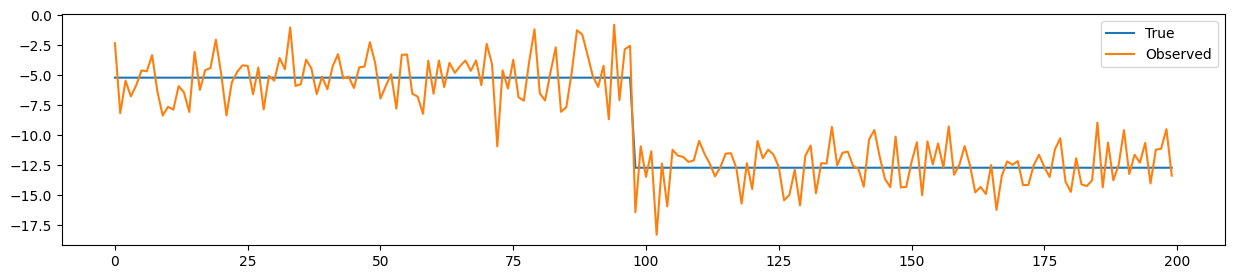

In [16]:
# generate signal
n_samples = 200
n_bkps = 1
n_dims = 1
sigma_noise = 2
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

fig, ax = fig_ax()
ax.plot(signal, label="True")
ax.plot(signal_with_noise, label="Observed")
_ = plt.legend()

We fit the noisy signal with a piecewise constant function with a single discontinuity. The best fit is the function which minimizes the norm of the residuals.

For a $T$-sample signal $y$ and an index $a$, this amounts to:

$$
\sum_{t< a} \|y_t-\bar{y}_{0..a}\|^2 + \sum_{t\geq a} \|y_t-\bar{y}_{a..T}\|^2
$$

where $\bar{y}_{\text{left}}$ and $\bar{y}_{\text{right}}$ are the empirical means of $\{y_0,\dots,y_{a-1}\}$ and $\{y_a,\dots,y_{T-1}\}$ respectively.

The detection procedure consists in finding the index $a$ that minimizes this sum of costs.

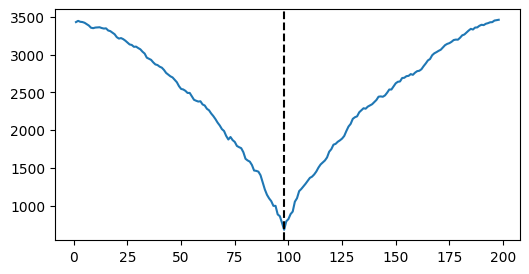

In [17]:
sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)

for mid_point in admissible_change_points:
    sum_of_cost = signal_with_noise[
        :mid_point
    ].var() * mid_point + signal_with_noise[mid_point:].var() * (
        n_samples - mid_point
    )
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]

# add a vertical dashed line
ax.axvline(detected_change_point, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What happens to the sum of costs when the noise varies?</p>
    <p>And when the number of samples increases?</p>
</div>

more noise --> minimum not as clear, change point less perceivable

more samples --> clearer minimum, change point more perceivable

To check if a change point is indeed present, let us do a t-test between the left part of the signal and the right part of the signal.

In [18]:
ttest_ind(
    signal_with_noise[:detected_change_point],
    signal_with_noise[detected_change_point:],
)

Ttest_indResult(statistic=array([28.55551676]), pvalue=array([3.94946524e-72]))

At first sight, the detected change seems to be statistically significant.

However, let us test this procedure on a pure noise signal.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Perform the same procedure as before on the pure noise signal. According to the t-test, is there a change point?</p>
    <p>What went wrong?</p>
</div>

Ttest_indResult(statistic=array([2.88201394]), pvalue=array([0.00438748]))

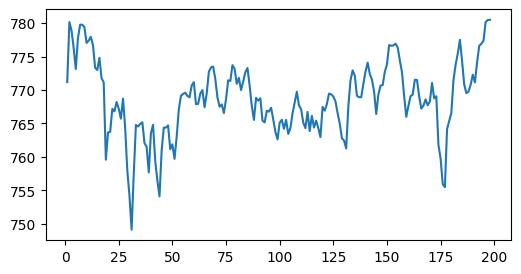

In [19]:
noise = np.random.normal(scale=sigma_noise, size=signal.shape)
sum_of_cost_list = list()

admissible_change_points = np.arange(1, n_samples - 1)

for mid_point in admissible_change_points:
    sum_of_cost = noise[
        :mid_point
    ].var() * mid_point + noise[mid_point:].var() * (
        n_samples - mid_point
    )
    sum_of_cost_list.append(sum_of_cost)

fig, ax = fig_ax(figsize=(6, 3))
ax.plot(admissible_change_points, sum_of_cost_list)

# take the minimum sum of costs
detected_change_point = admissible_change_points[np.argmin(sum_of_cost_list)]
ttest_ind(
    noise[:detected_change_point],
    noise[detected_change_point:],
)

We will introduce later a criterion to assess the presence of a change.

### Multiple change points (known $K$)

To extend the detection to more than one change, we simply some the costs of each segment defined by the $K$ change points $t_1,\dots,t_K$:

$$
\sum_{t=0}^{t_1-1} \|y_t-\bar{y}_{0..t_1}\|^2 + \sum_{t=t_1}^{t_2-1} \|y_t-\bar{y}_{t_1..t_2}\|^2 + \dots + \sum_{t=t_K}^{T-1} \|y_t-\bar{y}_{t_K..T}\|^2.
$$

We minimize over the $t_k$, using dynamic programming. (Other methods exists, e.g. binary segmentation, bottom-up, window-based, but are only approximate.)

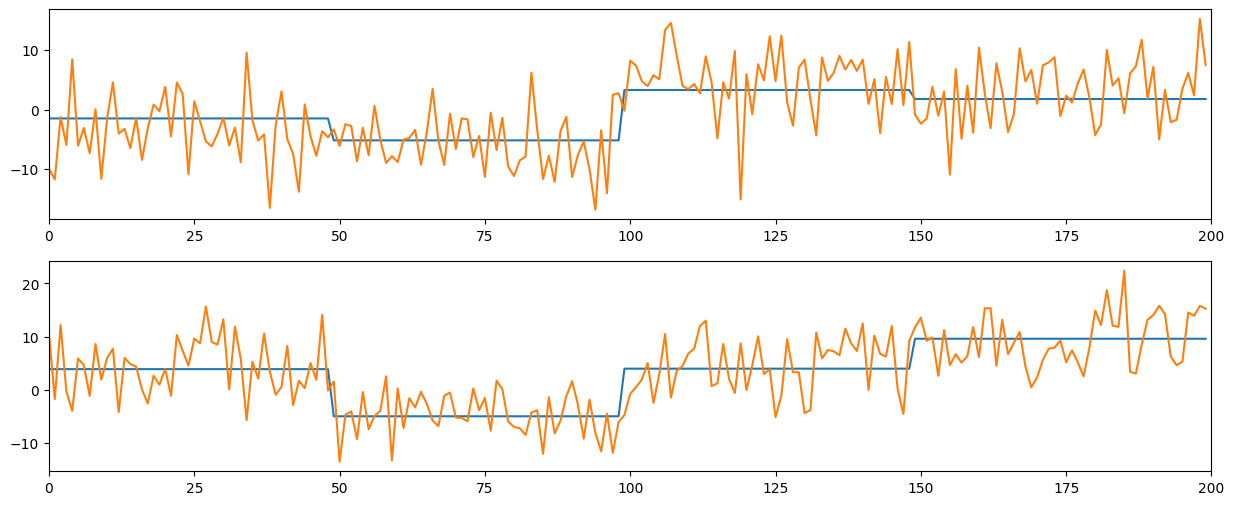

In [20]:
# generate signal
n_samples = 200
n_bkps = 3
n_dims = 2
sigma_noise = 5
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=0
)
signal_with_noise = signal + np.random.normal(
    scale=sigma_noise, size=signal.shape
)

# display
fig, ax_arr = fig_ax(nrows=n_dims)
for (signal1d, signal1d_with_noise, ax) in zip(
    signal.T, signal_with_noise.T, ax_arr
):
    ax.plot(signal1d)
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

Perform change point detection using dynamic programming.

In [21]:
algo = rpt.Dynp(model="l2", jump=1).fit(signal_with_noise)

error: 17.0 samples


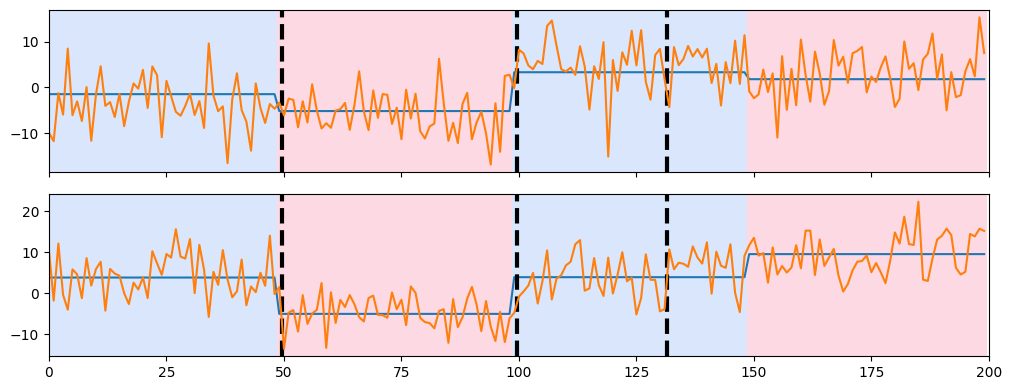

In [22]:
predicted_bkps = algo.predict(n_bkps=n_bkps)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
for (signal1d_with_noise, ax) in zip(signal_with_noise.T, ax_arr):
    ax.plot(signal1d_with_noise)
    ax.set_xlim(0, n_samples)

print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

### Penalized change point detection (unknown $K$)

When the number of changes $K$, we can perform penalized detection:

$$
\min_{K, t_1,\dots,t_K} \left[ \left(\sum_k \sum_{t=t_k}^{t_{k+1}-1} \|y_t-\bar{y}_{t_k..t_{k+1}}\|^2 \right) + \beta K \right]
$$

when $\beta>0$ controls the trade-off between the data fidelity and the complexity of the segmentation.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>When the regularization parameter increases, do we detect more or less changes?</p>
</div>

higher $\beta$ --> lower $K$

This formulation generalizes a number of model selection criterion, for instance the well-known BIC criterion: $\beta_{\text{BIC}}=2\sigma^2\log(T)$ (where $T$ is the number of samples) for a univariate Gaussian process with piecewise constant mean and *known* variance.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>For a piecewise constant univariate signal with Gaussian noise, use BIC (with one and zero change) to asses the presence of a change.</p>
</div>

In [23]:
signal, bkps = rpt.pw_constant(n_samples=n_samples, n_features=1, n_bkps=1, noise_std=1)

# use the already available cost function
cost = rpt.costs.CostL2().fit(signal)
cost.error(10, 20)  # cost on signal[10:20]

algo = rpt.Dynp(model="l2", jump=1).fit(signal)
bkps_pred = algo.predict(n_bkps=1)
break_point = bkps_pred[0]

penalized_sum_of_cost_1_change = cost.error(0, break_point) + cost.error(break_point, n_samples) + 2*1*np.log(n_samples) # sum of costs + beta * 1
penalized_sum_of_cost_0_change = cost.error(0, n_samples) # sum of costs + beta * 0


In [24]:
print(f"BIC with one change: {penalized_sum_of_cost_1_change:.2f}")
print(f"BIC with zero change: {penalized_sum_of_cost_0_change:.2f}")

if penalized_sum_of_cost_0_change > penalized_sum_of_cost_1_change:
    print("There is one change.")
else:
    print("There is no change.")

BIC with one change: 188.92
BIC with zero change: 4529.39
There is one change.


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same with the pure noise signal.</p>
</div>

In [25]:
signal = np.random.normal(scale=1, size=n_samples)

# use the already available cost function
cost = rpt.costs.CostL2().fit(signal)
cost.error(10, 20)  # cost on signal[10:20]

algo = rpt.Dynp(model="l2", jump=1).fit(signal)
bkps_pred = algo.predict(n_bkps=1)
breakpoint = bkps_pred[0] # brps_pred[1] est la taille du signal 

# (erreur quadratique sur segment gauche + erreur quadratique sur segment de droite) (car 1 rupture) + BIC * nb de segments (ici 2)
penalized_sum_of_cost_1_change = cost.error(0, breakpoint) + cost.error(breakpoint, n_samples) +  2*2*1*np.log(n_samples) # sum of costs + beta * 1 
# (erreur quadratique sur tout le segment (car 0 rupture) + BIC * nb de segments (ici 1)
penalized_sum_of_cost_0_change = cost.error(0, n_samples) + 2*1*np.log(n_samples) # sum of costs + beta * 0

print(f"BIC with one change: {penalized_sum_of_cost_1_change:.2f}")
print(f"BIC with zero change: {penalized_sum_of_cost_0_change:.2f}")

if penalized_sum_of_cost_0_change > penalized_sum_of_cost_1_change:
    print("There is one change.")
else:
    print("There is no change.")

BIC with one change: 214.91
BIC with zero change: 208.09
There is no change.


Let us apply the BIC criterion on a signal with several changes.

In [26]:
# generate signal
n_samples = 1000
n_bkps = 5
n_dims = 1
noise_std = 1
signal, bkps = rpt.pw_constant(
    n_samples=n_samples, n_features=n_dims, n_bkps=n_bkps, noise_std=noise_std
)

Penalized change point detection is performed with PELT.

error: 2.0 samples


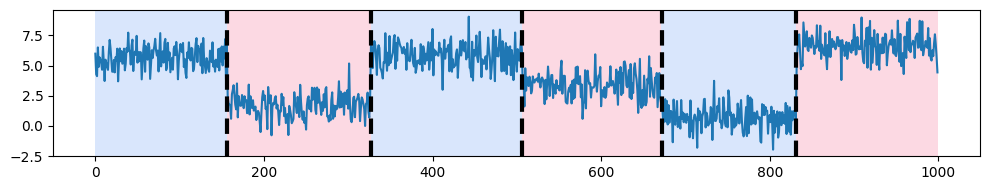

In [27]:
pen_bic = 2 * np.log(n_samples) * noise_std**2 
predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(
    signal=signal, pen=pen_bic
)

fig, ax_arr = rpt.display(signal, bkps, predicted_bkps)
print(f"error: {hausdorff(bkps, predicted_bkps)} samples")

## General distribution change (parametric)

By setting the cost function to the negative max log likelihood, we can detect any (parametric) distribution change.

$$
c(y_{a..b}) = -\max_\theta\log L(y_{a..b}, \theta)
$$

where $L(\cdot, \theta)$ is the likelihood of a distribution parametrized by $\theta$.

### Multivariate Gaussian

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Assume a multivariate Gaussian process with piecewise constant parameters (mean and covariance matrix). Derive the associated cost function and BIC penalty.</p>
</div>

For $t = a,\dots,b-1$,
$y_t \sim \mathcal{N}(\mu, \Sigma)$

Max likelihood : 
$$\hat{\mu} = \sum_{t=a}^{b-1} y_t$$
$$\hat{\Sigma} = \sum_{t=a}^{b-1} (y_t - \hat{\mu}) (y_tu - \hat{\mu})^\top$$

$$c(y_{a,\dots,b}) = (b-a) \log \det \hat{\Sigma}$$

We can define a cost function that can be used in `Dynp` and `Pelt`.

In [49]:
class MultivariateNormalCost(BaseCost):

    """Custom cost for piecewise Poisson signals."""

    # The 2 following attributes must be specified for compatibility.
    model = "Poisson"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation  cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        subsignal = self.signal[start:end]
        cov_mat = np.cov(subsignal.T)
        _, val = np.linalg.slogdet(cov_mat)
        return (end-start)*val

In [32]:
path_to_assignment3 = "/content/drive/MyDrive/Cours_MVA/2nd semestre/Times series and ML/Assignment3/"

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Detect the change-points in the following signal.</p>
</div>

In [51]:
signal = np.loadtxt(path_to_assignment3 + "pw_normal.csv")

In [52]:
predicted_bkps = rpt.Dynp(jump=5, custom_cost=MultivariateNormalCost()).fit_predict(signal=signal, n_bkps=3)
predicted_bkps

[125, 245, 375, 500]

[3, 5, 7, 500] avec jump =1

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are known limitations of the BIC criterion?</p>
</div>

Asymptotic, so poor when low nb of points
Need for a model to obtain a criterion
need to estimate other things s.a. noise

# Experiments


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [ ]:
signal, symbols = generate_signal()

In [ ]:
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Display the short-term fourier transform of a signal. What do you observe?</p>
</div>

In [ ]:
from scipy.signal import stft

f, t, Zxx = stft(signal, FS, nperseg=256)

plt.figure()
plt.imshow(np.abs(Zxx), aspect='auto', cmap='hot', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Design a change-point detection algorithm to find the segments of silence/sound. First assume that you know the number of changess, then relax this assumption.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Classify each segment in symbol/silence.</p>
</div>

In [ ]:
signal_freq = np.abs(Zxx.T)
predicted_bkps = rpt.Dynp(jump=10, min_size=10, model="l2", custom_cost=MultivariateNormalCost()).fit_predict(signal=signal_freq, n_bkps=14)
predicted_bkps

In [ ]:
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in predicted_bkps[:-1]:
    plt.axvline(t[b])

In [ ]:
#pen_manual = 2 * np.log(len(signal_freq)) * np.var(signal_freq)
# 2*np.log(signal_freq.shape[0])
algo = rpt.Pelt(jump=5, min_size=1, model="l2").fit(signal=signal_freq)
predicted_bkps = algo.predict(pen=1.9)

plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

for b in predicted_bkps[:-1]:
    plt.axvline(t[b])

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Give the sequences of symbols for the two following sounds.</p>
</div>

In [ ]:
sound_1 = np.loadtxt("signal_1.csv")
sound_2 = np.loadtxt("signal_2.csv")
